In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
from jax import pmap
import pickle as pk



In [2]:
import sys
sys.path.append('/home/amawi/projects/nn_ansatz/src')

import jax
import jax.random as rnd
import jax.numpy as jnp
from jax import vmap, jit, grad, pmap
from jax.experimental.optimizers import adam
from jax import tree_util
from tqdm.notebook import trange

from functools import partial

from nn_ansatz import *
from nn_ansatz.vmc import *

cfg = config = setup(system='LiSolidBCC',
               n_pre_it=0,
               n_walkers=64,
               n_layers=2,
               n_sh=32,
               n_ph=8,
               opt='kfac',
               n_det=2,
               print_every=1,
               save_every=5000,
               n_it=1000)

logger = Logging(**cfg)

keys = rnd.PRNGKey(cfg['seed'])
if bool(os.environ.get('DISTRIBUTE')) is True:
    keys = rnd.split(keys, cfg['n_devices']).reshape(cfg['n_devices'], 2)

mol = SystemAnsatz(**cfg)
vwf = create_wf(mol)
sampler = create_sampler(mol, vwf)
params = initialise_params(mol, keys)

walkers = initialise_walkers(mol, vwf, sampler, params, keys, walkers=None)

def compute_potential_energy_solid_i(walkers, 
                                     r_atoms, 
                                     z_atoms, 
                                     kappa, 
                                     real_lattice, 
                                     reciprocal_lattice, 
                                     q_q, 
                                     charges, 
                                     volume, 
                                     rl_factor):

    """
    :param walkers (n_el, 3):
    :param r_atoms (n_atoms, 3):
    :param z_atoms (n_atoms, ):

    Pseudocode:
        - compute the potential energy (pe) of the cell
        - compute the pe of the cell electrons with electrons outside
        - compute the pe of the cell electrons with nuclei outside
        - compute the pe of the cell nuclei with nuclei outside
    """

    # put the walkers and r_atoms together
    walkers = jnp.concatenate([r_atoms, walkers], axis=0)  # (n_particle, 3)

    # compute the Rs0 term
    p_p_vectors = vector_sub(walkers, walkers)
    p_p_distances = compute_distances(walkers, walkers)
    # p_p_distances[p_p_distances < 1e-16] = 1e200  # doesn't matter, diagonal dropped, this is just here to suppress the error
    Rs0 = jnp.tril(erfc(kappa * p_p_distances) / p_p_distances, k=-1)  # is half the value

    # compute the Rs > 0 term
    ex_walkers = vector_add(walkers, real_lattice)  # (n_particle, n_lattice, 3)
    tmp = walkers[:, None, None, :] - ex_walkers[None, ...]  # (n_particle, n_particle, n_lattice, 3)
    ex_distances = jnp.sqrt(jnp.sum(tmp**2, axis=-1))  
    Rs1 = jnp.sum(erfc(kappa * ex_distances) / ex_distances, axis=-1)
    real_sum = (q_q * (Rs0 + 0.5 * Rs1)).sum((-1, -2))
    
    # compute the constant factor
    self_interaction = - 0.5 * jnp.diag(q_q * 2 * kappa / jnp.sqrt(jnp.pi)).sum()
    constant = - 0.5 * charges.sum()**2 * jnp.pi / (kappa**2 * volume)  # is zero in neutral case

    # compute the reciprocal term reuse the ee vectors
    exp = jnp.real(jnp.sum(rl_factor[None, None, :] * jnp.exp(1j * p_p_vectors @ jnp.transpose(reciprocal_lattice)), axis=-1))
    reciprocal_sum = 0.5 * (q_q * exp).sum((-1,-2))
    
    potential = real_sum + reciprocal_sum + constant + self_interaction
    return potential, real_sum, reciprocal_sum, constant, self_interaction

    
def create_potential_energy(mol):
    """

    Notes:
        - May need to shift the origin to the center to enforce the spherical sum condition
        - I am now returning to length of unit cell units which is different to the unit cell length I was using before. How does this affect the computation?
        - Is the reciprocal height computed in the correct way?
    """

    if mol.periodic_boundaries:

        real_basis = mol.real_basis
        reciprocal_basis = mol.reciprocal_basis
        kappa = mol.kappa
        volume = mol.volume

        real_lattice = generate_lattice(real_basis, mol.real_cut)  # (n_lattice, 3)
        reciprocal_lattice = generate_lattice(reciprocal_basis, mol.reciprocal_cut)
        rl_inner_product = inner(reciprocal_lattice, reciprocal_lattice)
        rl_factor = (4*jnp.pi / volume) * jnp.exp(- rl_inner_product / (4*kappa**2)) / rl_inner_product  

        e_charges = jnp.array([-1. for i in range(mol.n_el)])
        charges = jnp.concatenate([mol.z_atoms, e_charges], axis=0)  # (n_particle, )
        q_q = charges[None, :] * charges[:, None]  # q_i * q_j  (n_particle, n_particle)

        _compute_potential_energy_solid_i = partial(compute_potential_energy_solid_i, 
                                                    kappa=kappa, real_lattice=real_lattice, reciprocal_lattice=reciprocal_lattice,
                                                    q_q=q_q, charges=charges, volume=volume, rl_factor=rl_factor)

        return vmap(_compute_potential_energy_solid_i, in_axes=(0, None, None))

    return vmap(compute_potential_energy_i, in_axes=(0, None, None))




version 		 140921
seed 		 369
n_devices 		 1
save_every 		 5000
print_every 		 1
exp_dir 		 /home/amawi/projects/nn_ansatz/src/scripts/validation/130921_plot_ewalds/experiments/LiSolidBCC/140921/junk/kfac_1lr-4_1d-3_1nc-4_m64_s32_p8_l2_det2/run0
events_dir 		 /home/amawi/projects/nn_ansatz/src/scripts/validation/130921_plot_ewalds/experiments/LiSolidBCC/140921/junk/kfac_1lr-4_1d-3_1nc-4_m64_s32_p8_l2_det2/run0/events
models_dir 		 /home/amawi/projects/nn_ansatz/src/scripts/validation/130921_plot_ewalds/experiments/LiSolidBCC/140921/junk/kfac_1lr-4_1d-3_1nc-4_m64_s32_p8_l2_det2/run0/models
opt_state_dir 		 /home/amawi/projects/nn_ansatz/src/scripts/validation/130921_plot_ewalds/experiments/LiSolidBCC/140921/junk/kfac_1lr-4_1d-3_1nc-4_m64_s32_p8_l2_det2/run0/models/opt_state
pre_path 		 /home/amawi/projects/nn_ansatz/src/scripts/validation/130921_plot_ewalds/experiments/LiSolidBCC/pretrained/s32_p8_l2_det2_1lr-4_i0.pk
timing_dir 		 /home/amawi/projects/nn_ansatz/src/scripts/validation/13

In [4]:

pe = pmap(create_potential_energy(mol), in_axes=(0, None, None))

pe(walkers, mol.r_atoms, mol.z_atoms)




(ShardedDeviceArray([[-13.144688 , -12.724692 ,  -7.531447 ,  -9.452775 ,
                       -9.33442  , -10.90015  ,  -7.990285 , -12.521355 ,
                      -14.694443 , -14.372334 , -10.071131 , -12.167753 ,
                      -17.176388 ,  -9.554413 , -21.105919 ,  -9.167974 ,
                      -15.233409 ,  -9.63291  , -10.886074 , -10.699591 ,
                      -11.791948 , -10.54067  , -12.692146 ,  -8.757788 ,
                      -11.222559 , -13.209532 ,  -8.91194  ,  -4.7688713,
                       -9.352827 ,  -8.9274   ,  -8.999275 ,  -7.528145 ,
                      -11.7774515,  -8.2251005,  -9.055263 , -12.385459 ,
                      -12.416143 ,  -9.77109  ,  -8.087435 , -14.068972 ,
                       -9.30205  , -11.4175415,  -8.201233 ,  -8.500793 ,
                       -9.786993 , -11.144163 , -12.394288 , -14.533681 ,
                      -16.890387 ,  -9.318469 ,  -7.852474 ,  -6.7550983,
                       -9.211878 , -12

In [7]:
# create the setup 
cfg = setup(system='LiSolid',
               n_walkers=128,
               n_layers=2,
               n_sh=32,
               n_ph=8,
               opt='adam',
               n_det=4,
               print_every=1,
               save_every=5000,
               kappa=1.,
               real_cut = 3,
               reciprocal_cut = 3)

key = rnd.PRNGKey(cfg['seed'])
keys = rnd.split(key, cfg['n_devices']).reshape(cfg['n_devices'], 2)

# create the molecule 
mol = SystemAnsatz(**cfg)

# create the wf
vwf = create_wf(mol)
params = initialise_params(mol, keys)
# d0s = initialise_d0s(mol, cfg['n_devices'], cfg['n_walkers_per_device'])

# create the potential energy 
# sampler, equilibrater = create_sampler(wf, vwf, mol, **cfg)
# walkers = mol.initialise_walkers(**cfg)
# walkers = equilibrater(params, walkers, d0s, keys, n_it=1000, step_size=0.02)
# with open('128walkers.pk', 'wb') as f:
#     pk.dump(walkers, f)
with open('128walkers.pk', 'rb') as f:
    walkers = pk.load(f)
# loop over cuts and plot the outcomes


version 		 140921
seed 		 369
n_devices 		 1
save_every 		 5000
print_every 		 1
exp_dir 		 /home/amawi/projects/nn_ansatz/src/scripts/validation/130921_plot_ewalds/experiments/LiSolid/140921/junk/adam_1lr-4_1d-3_1nc-4_m128_s32_p8_l2_det4/run2
events_dir 		 /home/amawi/projects/nn_ansatz/src/scripts/validation/130921_plot_ewalds/experiments/LiSolid/140921/junk/adam_1lr-4_1d-3_1nc-4_m128_s32_p8_l2_det4/run2/events
models_dir 		 /home/amawi/projects/nn_ansatz/src/scripts/validation/130921_plot_ewalds/experiments/LiSolid/140921/junk/adam_1lr-4_1d-3_1nc-4_m128_s32_p8_l2_det4/run2/models
opt_state_dir 		 /home/amawi/projects/nn_ansatz/src/scripts/validation/130921_plot_ewalds/experiments/LiSolid/140921/junk/adam_1lr-4_1d-3_1nc-4_m128_s32_p8_l2_det4/run2/models/opt_state
pre_path 		 /home/amawi/projects/nn_ansatz/src/scripts/validation/130921_plot_ewalds/experiments/LiSolid/pretrained/s32_p8_l2_det4_1lr-4_i1000.pk
timing_dir 		 /home/amawi/projects/nn_ansatz/src/scripts/validation/130921_plo

In [8]:
print(mol.volume)

135.77907


In [9]:

kappas = np.linspace(0.25, 2, 8)
real_cuts = np.arange(1, 7)
reciprocal_cuts = np.arange(1, 7)

e_charges = jnp.array([-1. for i in range(mol.n_el)])
charges = jnp.concatenate([mol.z_atoms, e_charges], axis=0)  # (n_particle, )
q_q = charges[None, :] * charges[:, None]  # q_i * q_j  (n_particle, n_particle)

pe = pmap(vmap(compute_potential_energy_solid_i, \
    in_axes=(0, None, None, None, None, None, None, None, None, None)), \
        in_axes=(0, None, None, None, None, None, None, None, None, None))

# compute_potential_energy_solid_i(walkers, 
#                                      r_atoms, 
#                                      z_atoms, 
#                                      kappa, 
#                                      real_lattice, 
#                                      reciprocal_lattice, 
#                                      q_q, 
#                                      charges, 
#                                      volume, 
#                                      rl_factor)

energies = []
for kappa in kappas:
    mol.kappa = kappa
    for real_cut in real_cuts:
        mol.real_cut = real_cut
        real_lattice = generate_lattice(mol.real_basis, mol.real_cut)
        for reciprocal_cut in reciprocal_cuts:
            mol.reciprocal_cut = reciprocal_cut
            reciprocal_lattice = generate_lattice(mol.reciprocal_basis, mol.reciprocal_cut)

            rl_inner_product = inner(reciprocal_lattice, reciprocal_lattice)
            rl_factor = (4*jnp.pi / mol.volume) * jnp.exp(- rl_inner_product / (4*kappa**2)) / rl_inner_product

            potential, real, reciprocal, constant, self_interaction = \
                pe(walkers, mol.r_atoms, mol.z_atoms, kappa, real_lattice, reciprocal_lattice, q_q, charges, mol.volume, rl_factor)

            results = [kappa, real_cut, reciprocal_cut, float(real.mean()), float(reciprocal.mean()), float(potential.mean())]
            energies.append(results)
            print(results)

data = pd.DataFrame(energies, columns=['kappa', 'real_cut', 'reciprocal_cut', 'real', 'reciprocal', 'potential'])


[0.25, 1, 1, -2.576477527618408, 0.0013592493487522006, -4.26768684387207]
[0.25, 1, 2, -2.576477527618408, 0.0013592493487522006, -4.26768684387207]
[0.25, 1, 3, -2.576477527618408, 0.0013592493487522006, -4.26768684387207]
[0.25, 1, 4, -2.576477527618408, 0.0013592493487522006, -4.26768684387207]
[0.25, 1, 5, -2.576477527618408, 0.0013592493487522006, -4.26768684387207]
[0.25, 1, 6, -2.576477527618408, 0.0013592493487522006, -4.26768684387207]
[0.25, 2, 1, -2.5813069343566895, 0.0013592493487522006, -4.272516250610352]
[0.25, 2, 2, -2.5813069343566895, 0.0013592493487522006, -4.272516250610352]
[0.25, 2, 3, -2.5813069343566895, 0.0013592493487522006, -4.272516250610352]
[0.25, 2, 4, -2.5813069343566895, 0.0013592493487522006, -4.272516250610352]
[0.25, 2, 5, -2.5813069343566895, 0.0013592493487522006, -4.272516250610352]
[0.25, 2, 6, -2.5813069343566895, 0.0013592493487522006, -4.272516250610352]
[0.25, 3, 1, -2.581313133239746, 0.0013592493487522006, -4.272522449493408]
[0.25, 3, 2,

KeyboardInterrupt: 

In [15]:
print(mol.r_atoms, mol.z_atoms, 

     kappa  real_cut  reciprocal_cut      real  reciprocal  potential
0     0.25         1               1 -7.418793    0.014679 -10.789251
1     0.25         1               2 -7.418793    0.014680 -10.789251
2     0.25         1               3 -7.418793    0.014680 -10.789251
3     0.25         1               4 -7.418793    0.014680 -10.789251
4     0.25         1               5 -7.418793    0.014680 -10.789251
..     ...       ...             ...       ...         ...        ...
283   2.00         6               2 -0.355727    8.453663 -18.983160
284   2.00         6               3 -0.355727   12.412180 -15.024645
285   2.00         6               4 -0.355727   14.709671 -12.727152
286   2.00         6               5 -0.355727   15.845195 -11.591628
287   2.00         6               6 -0.355727   16.340883 -11.095941

[288 rows x 6 columns]


kappa:  0.25


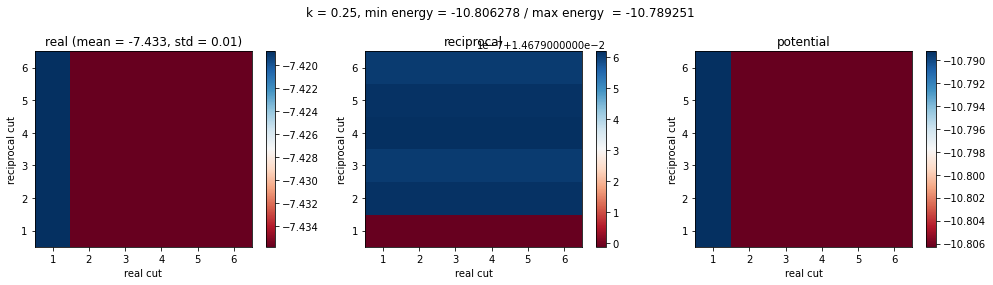

kappa:  0.5


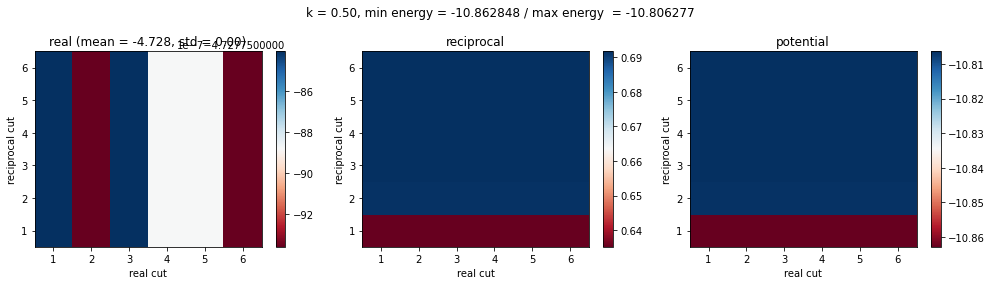

kappa:  0.75


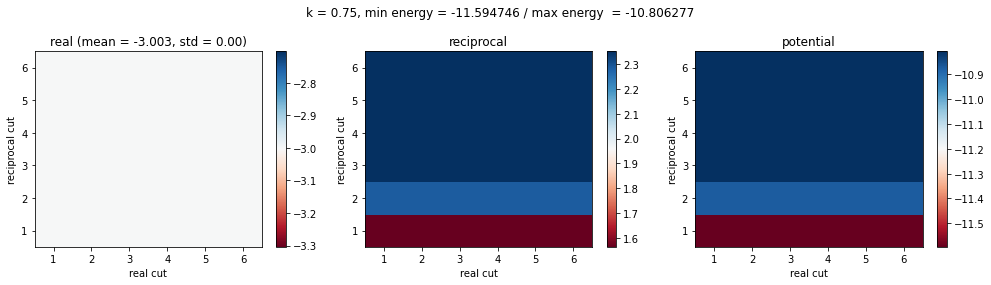

kappa:  1.0


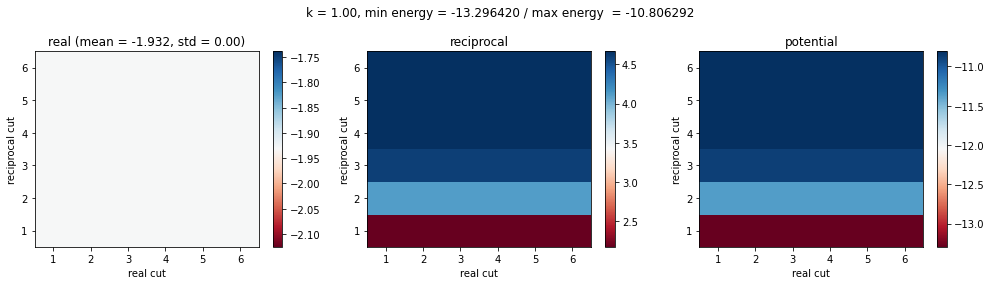

kappa:  1.25


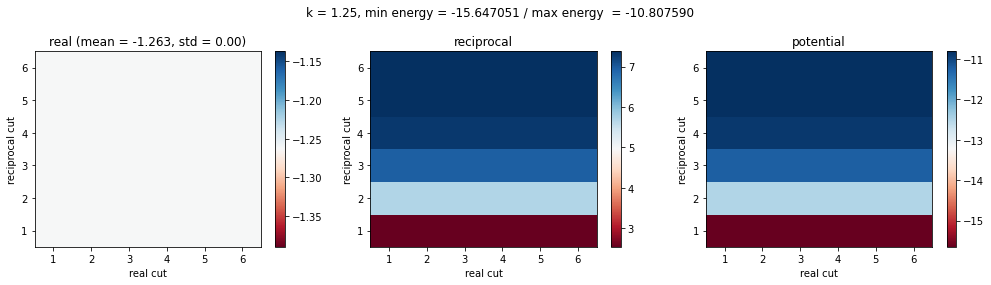

kappa:  1.5


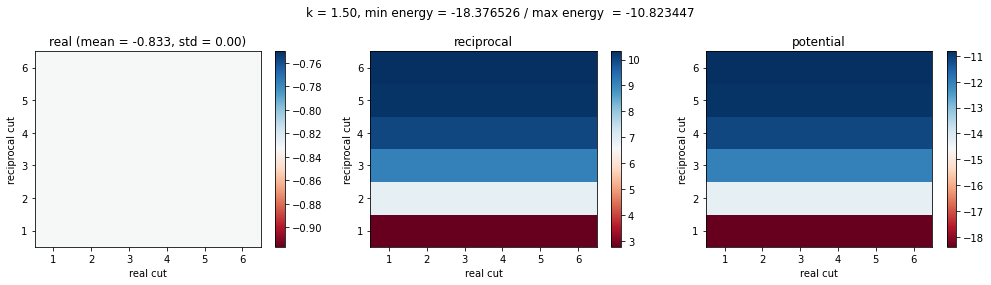

kappa:  1.75


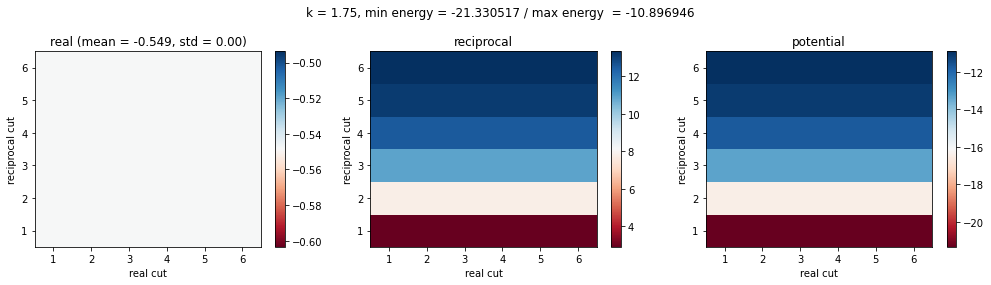

kappa:  2.0


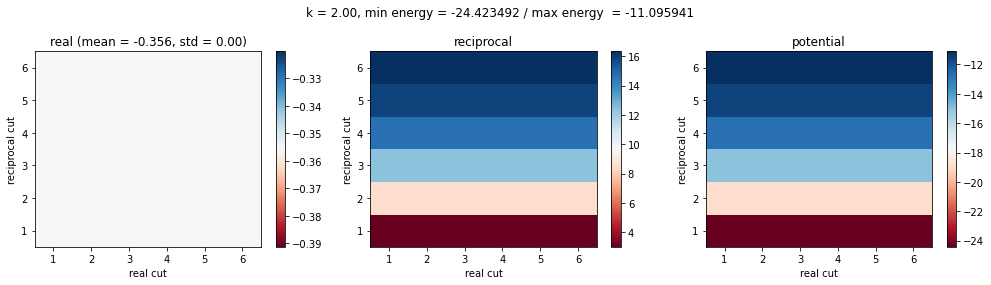

In [14]:

X, Y = np.meshgrid(real_cuts, reciprocal_cuts)

for kappa in kappas:
    print('kappa: ', kappa)
    fig, axs = plt.subplots(1, 3, figsize=(14, 4))
    
    for z, ax in zip(['real', 'reciprocal', 'potential'], axs):
        plot_data = data[data.kappa == kappa].pivot(index='reciprocal_cut', columns='real_cut', values=z)
        p = ax.pcolor(X, Y, plot_data.values, cmap=cm.RdBu, vmin=plot_data.min().min(), vmax=plot_data.max().max(), shading='auto')
        ax.set_xlabel('real cut')
        ax.set_ylabel('reciprocal cut')
        if z == 'real': z = 'real (mean = %.3f, std = %.2f)' % (np.mean(plot_data.values), np.std(plot_data.values))
        ax.set_title(z)
        cb = fig.colorbar(p, ax=ax)
    fig.suptitle('k = %.2f, min energy = %.6f / max energy  = %.6f' % (kappa, plot_data.min().min(), plot_data.max().max()))
    fig.tight_layout()
        
    plt.show()